# Gatys Implementation of Neural Style Transfer

## Imports

In [652]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.optim as optim
import requests
from torchvision import models, transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### Parameters

In [653]:
#Parameters to update

name_content = "paris"
name_style = "francis-bacon_1909/bacon_3"
name_color = "paris"

In [654]:
content_url = "images_test/"+name_content+".jpg"
style_url = "bd-peintres/"+name_style+".jpg"
#color_url = "bd-peintres/"+name_color+".jpg"
color_url = "images_test/"+name_color+".jpg"

#link belowe for Alejandro
#style_url = "../projet/data/bd-peintres-v2/"+name_style+".jpg"

#gerard-garouste_1946/garouste_2"
#gerard-garouste_1946/garouste_4"
#paul-signac_1863/signac_7"
#willem-de-kooning_1904/de-kooning_4"
#max-ernst_1891/ernst_4"
#marc-chagall_1887/chagall_8"

#Vasarely has a lot of color and shapes" 
#victor-vasarely_1906/vasarely_36"

#vincent-van-gogh_1853/Starry_Night"

## Load VGG19 model

In [655]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [656]:
# Put the model in GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Color Transfer and Histogram Plotting

In [657]:
def compute_statistics(image):
    """ Compute the mean and covariance of the LAB channels. """
    reshaped_image = image.reshape(-1, 3)
    mean = np.mean(reshaped_image, axis=0)
    covariance = np.cov(reshaped_image, rowvar=False)
    return mean, covariance


def color_transfer(style_image, content_image):
    # Convert images from RGB to LAB
    # style_lab = cv2.cvtColor(style_image, cv2.COLOR_RGB2LAB)
    # content_lab = cv2.cvtColor(content_image, cv2.COLOR_RGB2LAB)

    style_lab = style_image
    content_lab = content_image
    
    # Calculate means and covariances for style and content images in LAB
    mu_s, sigma_s = compute_statistics(style_lab)
    mu_c, sigma_c = compute_statistics(content_lab)

    # Perform Cholesky decomposition on content covariance matrix
    chol_c = np.linalg.cholesky(sigma_c)
    eigenvalues, eigenvectors = np.linalg.eigh(sigma_s)
    sigma_s_half = eigenvectors @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T
    A = chol_c @ np.linalg.inv(sigma_s_half)

    # Calculate the translation vector b
    b = mu_c - A @ mu_s

    # Apply the transformation to each pixel
    transformed_lab = (style_lab.reshape(-1, 3) @ A.T + b).clip(0, 255).astype(np.uint8)
    transformed_lab = transformed_lab.reshape(style_lab.shape)

    # Convert transformed LAB back to RGB
    #transformed_image = cv2.cvtColor(transformed_lab, cv2.COLOR_LAB2RGB)
    transformed_image = transformed_lab 
    
    return transformed_image

def plot_histogram(image, title, ax):
    """ Plot the histogram for each RGB channel. """
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=color)
        #Legend of color
        ax.legend(['Red', 'Green', 'Blue'])
    ax.set_xlim([0, 256])
    ax.set_title(title)

def load_and_transform_images(style_path, content_path, color_path=None):
    # Load images
    style_image = cv2.imread(style_path)
    content_image = cv2.imread(content_path)

    if color_path is not None:
        color_image = cv2.imread(color_path)
        # Dummy transformation: convert style image color space as an example
        transformed_image = color_transfer(style_image, color_image)

        # Convert images to RGB for display and histogram calculation
        style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
        content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
        
        return style_image, content_image, transformed_image, color_image

    else :
        # Dummy transformation: convert style image color space as an example
        transformed_image = color_transfer(style_image, content_image)    
    
        # Convert images to RGB for display and histogram calculation
        style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
        content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
        
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
        
        return style_image, content_image, transformed_image, None

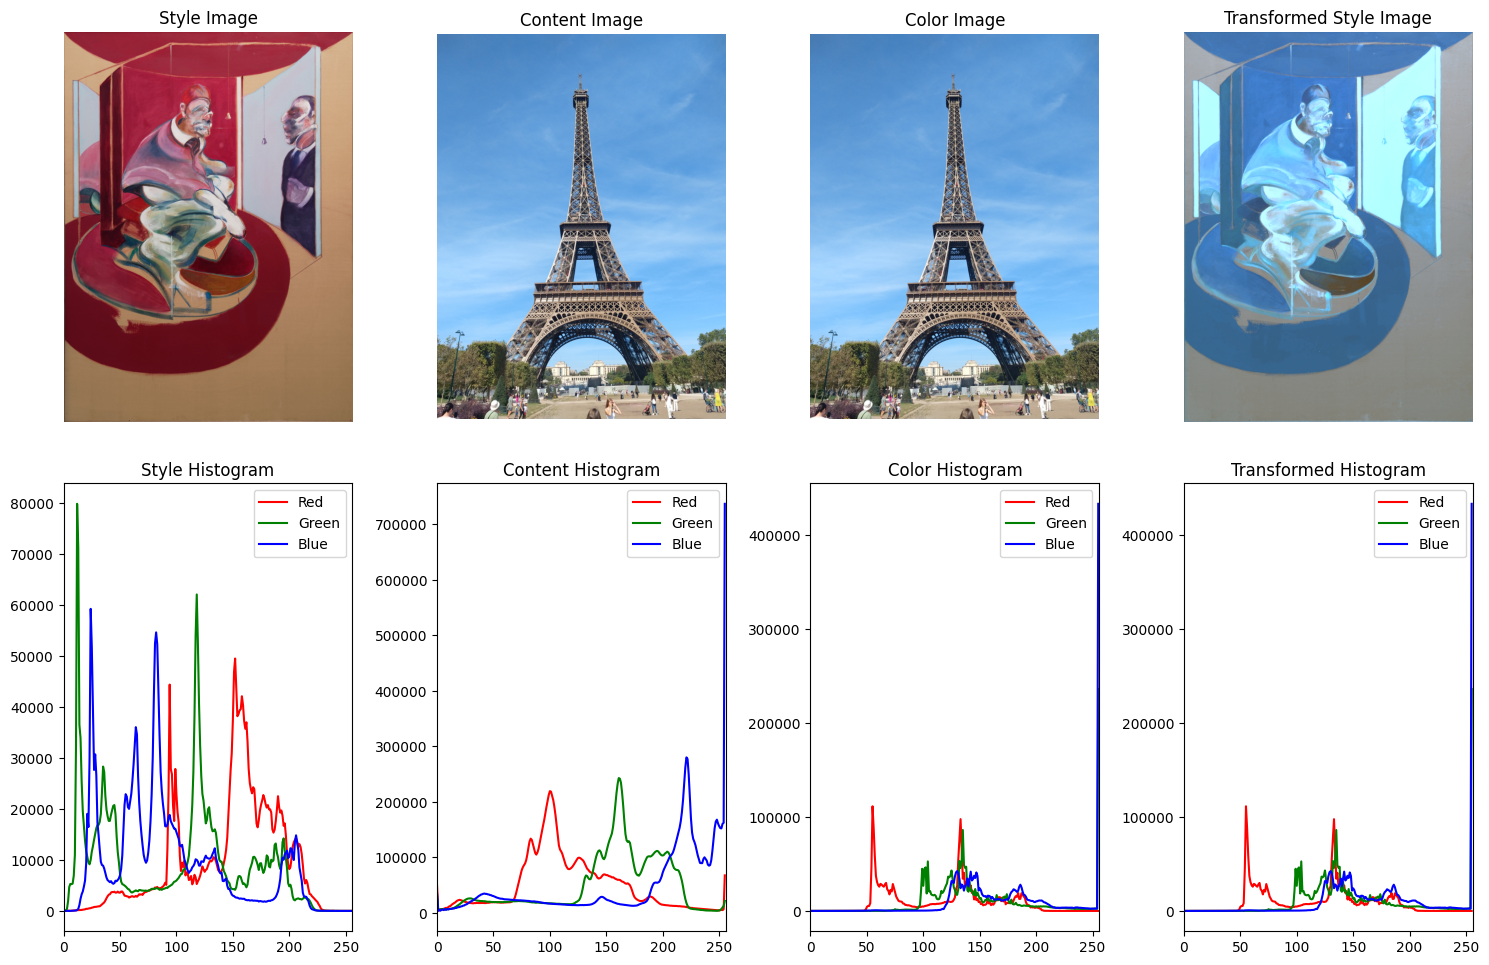

In [658]:
# Paths to the images
# Load and transform images
style_image, content_image, transformed_image, color_image = load_and_transform_images(style_url, content_url,color_url)

fig, axs = plt.subplots(2, 4, figsize=(15, 10))

# Plot images
axs[0, 0].imshow(style_image)
axs[0, 0].set_title('Style Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(content_image)
axs[0, 1].set_title('Content Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(color_image)
axs[0, 2].set_title('Color Image')
axs[0, 2].axis('off')

axs[0, 3].imshow(transformed_image)
axs[0, 3].set_title('Transformed Style Image')
axs[0, 3].axis('off')


# Plot histograms
plot_histogram(style_image, 'Style Histogram', axs[1, 0])
plot_histogram(content_image, 'Content Histogram', axs[1, 1])
plot_histogram(transformed_image, 'Color Histogram', axs[1, 2])
plot_histogram(color_image, 'Transformed Histogram', axs[1, 3])

# Adjust layout
plt.tight_layout()
plt.show()


parts_style = name_style.split("/")
parts_color = name_color.split("/")

style_img = parts_style[-1]
color_img = parts_color[-1]

name_image = name_content + "_" + style_img + "_" + color_img  + ".png"

fig.savefig("test/transferColor/"+name_image)

## Load content and style images

In [659]:
# Load the image and convert it to a tensor

def load_image(img, max_size=400, shape=None):
    image = Image.fromarray(img)
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = min(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size), #resizes min size (w or h) keeping aspect ratio
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))]) #normalized with ImageNet mean and std

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image

In [660]:
# Function to convert tensor to image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    
    return image

In [661]:
content = load_image(content_image).to(device)
style = load_image(style_image, shape=content.shape[-2:]).to(device)
color = load_image(color_image, shape=content.shape[-2:]).to(device)
transformed = load_image(transformed_image, shape=content.shape[-2:]).to(device)

(-0.5, 399.5, 532.5, -0.5)

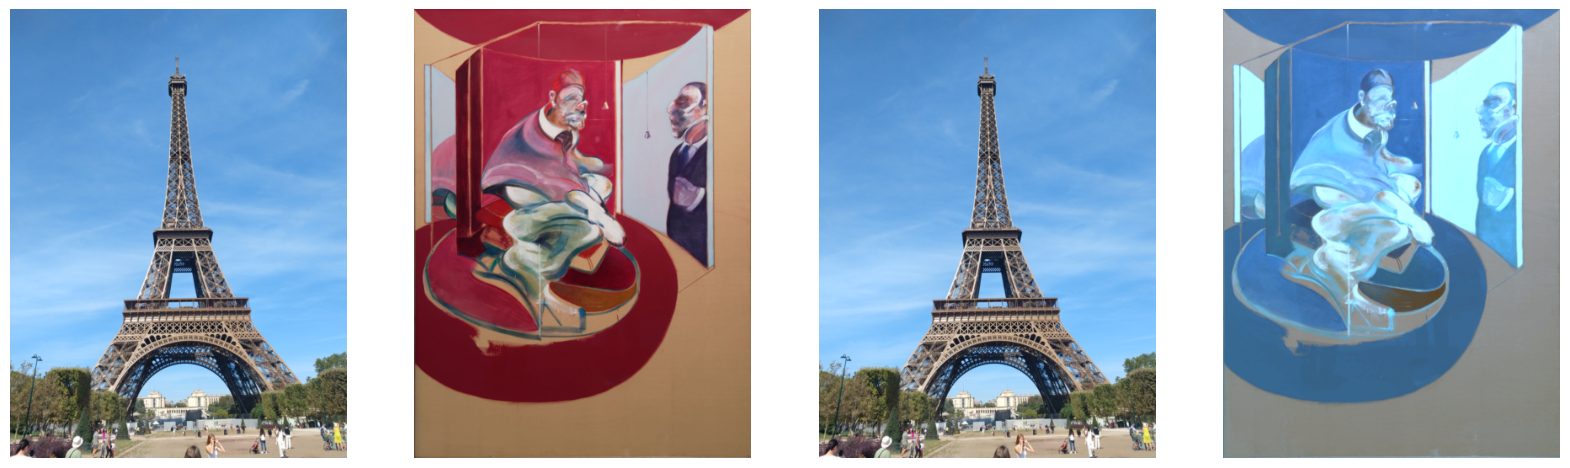

In [662]:
# Display the images
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(color))
ax3.axis('off')
ax4.imshow(im_convert(transformed))
ax4.axis('off')




## Quantitative Measures

c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


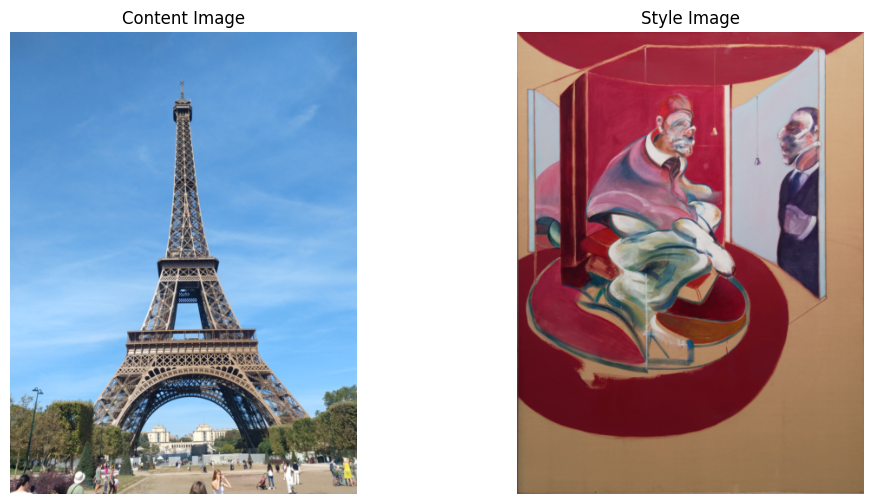

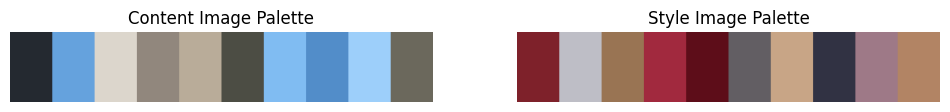

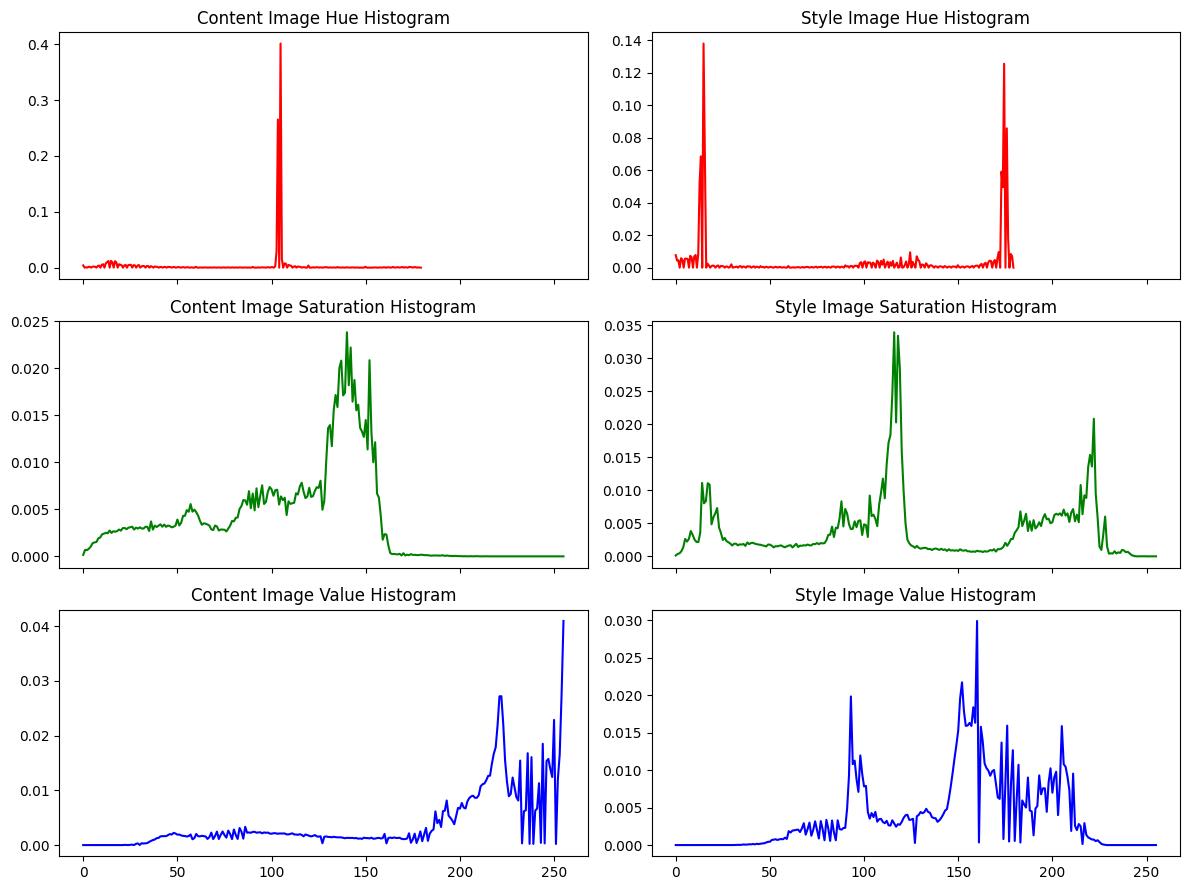

Palette color distance (CIEDE2000): 78.00078634014376

 Remark: in Correlation and Intersection the bigger the values, the more similar the histograms are in the other metrics is the opposite

Correlation: -0.002319002170163608
Chi-Squared: 3810.372298849318
Intersection: 3.6635978796257405
Bhattacharyya: 0.9131412279526334
Kullback-Leibler divergence: 487.24003398750267


In [663]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from skimage.color import rgb2lab, deltaE_ciede2000
import cv2
import torch

# Function to convert tensor to an image for display
def im_convert(tensor):
    image = tensor.cpu().clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)
    return image

# Function to extract color palette using k-means clustering with 10 clusters
def extract_palette(image, num_colors=10, random_seed=42):
    if isinstance(image, Image.Image):
        image = np.array(image)
    elif isinstance(image, np.ndarray):
        pass
    else:
        raise TypeError("Input should be a PIL Image or NumPy array")

    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=num_colors, random_state=random_seed)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    return colors

# Function to display the color palette
def plot_palette(colors, ax):
    palette = np.zeros((50, 300, 3), dtype=np.uint8)
    steps = 300 // len(colors)
    for i, color in enumerate(colors):
        palette[:, i*steps:(i+1)*steps, :] = color.astype(np.uint8)
    ax.imshow(palette)
    ax.axis('off')

# Convert RGB colors to Lab color space
def rgb_to_lab(colors):
    colors = np.array(colors).reshape(1, -1, 3)
    lab_colors = rgb2lab(colors)
    return lab_colors.reshape(-1, 3)

# Compute the color distance between two palettes
def compute_palette_distance(palette1, palette2):
    lab_palette1 = rgb_to_lab(palette1)
    lab_palette2 = rgb_to_lab(palette2)

    distances = []
    used_indices = set()

    for color1 in lab_palette1:
        min_distance = float('inf')
        best_index = -1

        for i, color2 in enumerate(lab_palette2):
            if i not in used_indices:
                distance = deltaE_ciede2000(color1, color2)
                if distance < min_distance:
                    min_distance = distance
                    best_index = i

        distances.append(min_distance)
        used_indices.add(best_index)

    return np.mean(distances)

# Compute histograms for each channel in HSV color space
def compute_histograms(image, bins=256):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hist_h, bin_edges_h = np.histogram(hsv_image[..., 0], bins=bins, range=(0, 180))
    hist_s, bin_edges_s = np.histogram(hsv_image[..., 1], bins=bins, range=(0, 256))
    hist_v, bin_edges_v = np.histogram(hsv_image[..., 2], bins=bins, range=(0, 256))
    hist_h = hist_h / np.sum(hist_h)
    hist_s = hist_s / np.sum(hist_s)
    hist_v = hist_v / np.sum(hist_v)
    return (hist_h, hist_s, hist_v), (bin_edges_h, bin_edges_s, bin_edges_v)

# Compute histogram distances between two images
def compute_histogram_distance(image1, image2):
    image1_hsv = cv2.cvtColor(image1, cv2.COLOR_RGB2HSV)
    image2_hsv = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)
    hist_img1 = cv2.calcHist([image1_hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_img2 = cv2.calcHist([image2_hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    methods = [cv2.HISTCMP_CORREL, cv2.HISTCMP_CHISQR, cv2.HISTCMP_INTERSECT, cv2.HISTCMP_BHATTACHARYYA, cv2.HISTCMP_KL_DIV]
    method_names = ["Correlation", "Chi-Squared", "Intersection", "Bhattacharyya", "Kullback-Leibler divergence"]
    results = {}
    for method, name in zip(methods, method_names):
        result = cv2.compareHist(hist_img1, hist_img2, method)
        results[name] = result
    return results

# Convert tensors to images
content_image = im_convert(content)
style_image = im_convert(style)
transformed_image = im_convert(transformed)

# Extract color palettes
content_palette = extract_palette((content_image * 255).astype(np.uint8))
style_palette = extract_palette((style_image * 255).astype(np.uint8))
transformed_palette = extract_palette((transformed_image * 255).astype(np.uint8))

plt.figure(figsize=(10, 4))

# Display images
plt.subplot(1, 3, 1)
plt.title("Content Image")
plt.imshow(content_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Style Image")
plt.imshow(style_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Transformed Image")
plt.imshow(transformed_image)
plt.axis('off')

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(9, 2))

# Plot palettes
axes[0].set_title("Content Image Palette")
plot_palette(content_palette, axes[0])

axes[1].set_title("Style Image Palette")
plot_palette(style_palette, axes[1])

axes[2].set_title("Transformed Image Palette")
plot_palette(transformed_palette, axes[2])

plt.show()

# Compute histograms
content_histograms, content_bin_edges = compute_histograms((content_image * 255).astype(np.uint8))
style_histograms, style_bin_edges = compute_histograms((style_image * 255).astype(np.uint8))
transformed_histograms, transformed_bin_edges = compute_histograms((transformed_image * 255).astype(np.uint8))

# Plot histograms
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharex=True)

# Plot Hue histograms
axes[0, 0].plot(content_bin_edges[0][:-1], content_histograms[0], color='r')
axes[0, 0].set_title("Content Image Hue Histogram")
axes[0, 1].plot(style_bin_edges[0][:-1], style_histograms[0], color='r')
axes[0, 1].set_title("Style Image Hue Histogram")
axes[0, 2].plot(transformed_bin_edges[0][:-1], transformed_histograms[0], color='r')
axes[0, 2].set_title("Transformed Image Hue Histogram")

# Plot Saturation histograms
axes[1, 0].plot(content_bin_edges[1][:-1], content_histograms[1], color='g')
axes[1, 0].set_title("Content Image Saturation Histogram")
axes[1, 1].plot(style_bin_edges[1][:-1], style_histograms[1], color='g')
axes[1, 1].set_title("Style Image Saturation Histogram")
axes[1, 2].plot(transformed_bin_edges[1][:-1], transformed_histograms[1], color='g')
axes[1, 2].set_title("Transformed Image Saturation Histogram")

# Plot Value histograms
axes[2, 0].plot(content_bin_edges[2][:-1], content_histograms[2], color='b')
axes[2, 0].set_title("Content Image Value Histogram")
axes[2, 1].plot(style_bin_edges[2][:-1], style_histograms[2], color='b')
axes[2, 1].set_title("Style Image Value Histogram")
axes[2, 2].plot(transformed_bin_edges[2][:-1], transformed_histograms[2], color='b')
axes[2, 2].set_title("Transformed Image Value Histogram")

plt.tight_layout()
plt.show()

# Print histogram distances
print('\n Remark: in Correlation and Intersection the bigger the values, the more similar the histograms are in the other metrics is the opposite\n')
print('Metrics between content and style images ')
# Compute the color palette distance
palette_distance = compute_palette_distance(content_palette, style_palette)
print(f"Palette color distance (CIEDE2000): {palette_distance}")

# Compute histogram distances
histogram_distances = compute_histogram_distance((content_image * 255).astype(np.uint8), (style_image * 255).astype(np.uint8))

for method, distance in histogram_distances.items():
    print(f"{method}: {distance}")

#if we would compare the histogram of the same image (same histograms) we would have the following values:

#Palette color distance (CIEDE2000): 0.0
#Correlation: 1.0
#Chi-Squared: 0.0
#Intersection: (the max value varies depending on the image)
#Bhattacharyya: 0.0
#Kullback-Leibler divergence: 0.0


## Comparisons between Transformed image with both Style and Content images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the functions im_convert, extract_palette, compute_palette_distance,
# compute_histogram_distance, and compute_histograms are defined as shown earlier

def plot_differences(transformed, content, style):
    print('Remark: in Correlation and Intersection the bigger the values, the more similar the histograms are in the other metrics is the opposite')
    # Convert tensors to images
    transformed_image = im_convert(transformed)
    content_image = im_convert(content)
    style_image = im_convert(style)

    # Extract color palettes
    transformed_image_palette = extract_palette((transformed_image * 255).astype(np.uint8))
    content_palette = extract_palette((content_image * 255).astype(np.uint8))
    style_palette = extract_palette((style_image * 255).astype(np.uint8))

    # Compute palette distances
    content_palette_distance = compute_palette_distance(transformed_image_palette, content_palette)
    style_palette_distance = compute_palette_distance(transformed_image_palette, style_palette)

    # Compute histogram distances
    content_histogram_distances = compute_histogram_distance((transformed_image * 255).astype(np.uint8), (content_image * 255).astype(np.uint8))
    style_histogram_distances = compute_histogram_distance((transformed_image * 255).astype(np.uint8), (style_image * 255).astype(np.uint8))

    # Create separate plots for each histogram metric
    methods = list(content_histogram_distances.keys())
    content_distances = list(content_histogram_distances.values())
    style_distances = list(style_histogram_distances.values())

    fig, axs = plt.subplots(2, 3, figsize=(13, 9))

    for i, (method, content_distance, style_distance) in enumerate(zip(methods, content_distances, style_distances)):
        ax = axs[i // 3, i % 3]
        ax.bar(['Content vs Transformed', 'Style vs Transformed'], [content_distance, style_distance], color=['blue', 'orange'])
        ax.set_ylabel('Distance')
        ax.set_title(f'{method}')

        for j, v in enumerate([content_distance, style_distance]):
            ax.text(j, v + 0.01, f"{v:.3f}", ha='center', va='bottom')  # Adjusted to show negative values properly

    # Plot palette distances in the last subplot
    ax_palette = axs[1, 2]
    palette_distances = [content_palette_distance, style_palette_distance]
    palette_labels = ['Content vs Transformed', 'Style vs Transformed']

    ax_palette.bar(palette_labels, palette_distances, color=['blue', 'orange'])
    ax_palette.set_xlabel('Comparison')
    ax_palette.set_ylabel('Palette Distance (CIEDE2000)')
    ax_palette.set_title('Palette Color Distance')

    for i, v in enumerate(palette_distances):
        ax_palette.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')  # Adjusted to show negative values properly

    fig.tight_layout()
    plt.show()

# Call the function to plot the differences
plot_differences(transformed, content, style)

## VGG19 layers

In [664]:
#Print the VGG arquitecture to see the different layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and style features

In [665]:
# get the features from the VGG model

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
    
    features = {}
    x = image
    for id, layer in model._modules.items():
        x = layer(x)
        if id in layers:
            features[layers[id]] = x
            
        #stop if the last conv layer is reached
        if id == '28':
            break
            
    return features

## Gram matrix

In [666]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram

# Features

In [667]:
content_features = get_features(content, vgg)
#style_features = get_features(style, vgg)
style_features = get_features(transformed, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


# Create a target image and prepare it for the optimization
target = content.clone().requires_grad_(True).to(device) #useless?

## Loss functions

In [668]:
# style_weights = [
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.},
    
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 1.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 1.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 1.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 1.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     ]


# style_weights = [
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 1.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 1.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 1.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 1.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     ]

style_weights = {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.5,'conv4_1': 0.5,'conv5_1': 0.5}

content_weight = 1  # alpha
style_weight = 1e6 # beta

## Updating Target Image

### Testing

Ratio:  1e-06
Total loss:  2339171.0
Total loss:  1151265.5
Total loss:  954354.8125
Total loss:  774779.5625
Total loss:  510015.71875


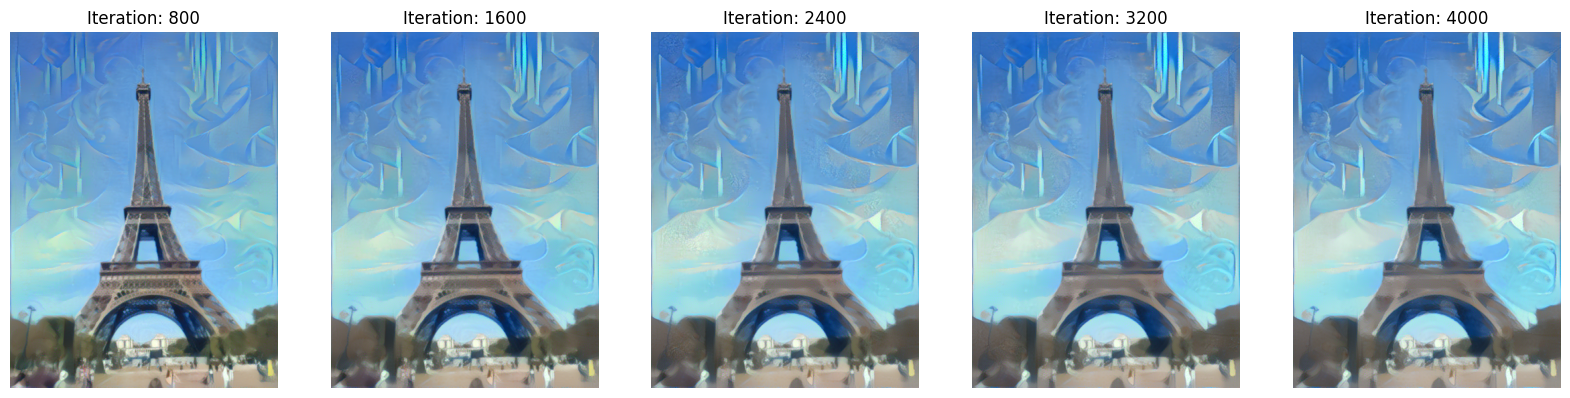

In [669]:
steps = 4000
learning_rate = 0.01
step_size = steps/5

images = []

print('Ratio: ', content_weight/style_weight)
image_target = {"beta": style_weight, "target": [], "iterations": []}

target = content.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) 

for i in range(1, steps+1):

    target_features = get_features(target, vgg)
        
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w) #maybe not needed?

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    #scheduler.step()
        
    if  i % step_size == 0:
        print('Total loss: ', total_loss.item())
        #print last lr by   current scheduler
        #print('LR: ', scheduler.get_last_lr())
        image_target["target"].append(im_convert(target))
        image_target["iterations"].append(i)
        # plt.imshow(im_convert(target))
        # plt.axis('off')
        # plt.show()

        #Plot image result over iterations
    if i == steps:
        fig, axs = plt.subplots(1,int(len(image_target["target"])), figsize=(20, 10))

        for ax, image, iteration in zip(axs.flatten(), image_target["target"], image_target["iterations"]):
            ax.imshow(image)
            ax.set_title(f"Iteration: {iteration}")
            ax.axis('off')
        plt.show()

    #fig.suptitle(str(style_w))

    # plt.imshow(im_convert(target))
    # plt.axis('off')
    plt.show()


#### Testing Different Betas

In [670]:
# steps = 4000
# learning_rate = 0.01
# step_size = steps/5

# images = []

# #add a to update the style_weight
# for weight in range(-6, 12, 2):
    
#     style_weight = 10**(weight) # beta
#     print('Style weight: ', style_weight)
#     print('Ratio: ', content_weight/style_weight)
#     image_target = {"beta": style_weight, "target": [], "iterations": []}
    
#     target = content.clone().requires_grad_(True).to(device)
    
#     optimizer = optim.Adam([target], lr=learning_rate)
#     #scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) 
    
#     for i in range(1, steps+1):

#         target_features = get_features(target, vgg)
        
#         content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
#         style_loss = 0
#         for layer in style_weights:
#             target_feature = target_features[layer]
#             target_gram = gram_matrix(target_feature)
#             style_gram = style_grams[layer]
#             layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
#             _, d, h, w = target_feature.shape
#             style_loss += layer_style_loss / (d * h * w) #maybe not needed?
            
#         total_loss = content_weight * content_loss + style_weight * style_loss
        
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
#         #scheduler.step()
        
#         if  i % step_size == 0:
#             print('Total loss: ', total_loss.item())
#             #print last lr by   current scheduler
#             #print('LR: ', scheduler.get_last_lr())
#             image_target["target"].append(im_convert(target))
#             image_target["iterations"].append(i)
#             # plt.imshow(im_convert(target))
#             # plt.axis('off')
#             # plt.show()

#         #Plot image result over iterations
#         if i == steps:
#             fig, axs = plt.subplots(1,int(len(image_target["target"])), figsize=(20, 10))

#             for ax, image, iteration in zip(axs.flatten(), image_target["target"], image_target["iterations"]):
#                 ax.imshow(image)
#                 ax.set_title(f"Iteration: {iteration}")
#                 ax.axis('off')
#             plt.show()
                
#             #fig.suptitle(str(style_w))

#             # plt.imshow(im_convert(target))
#             # plt.axis('off')
#             plt.show()

#     #save the final image in an array with the ratio alpha/beta
#     images.append({'image': im_convert(target), 'ratio': content_weight/style_weight})


#### Testing Different Style Weights

In [671]:
# show_every = 100
# #optimizer = optim.Adam([target], lr=0.003)
# steps = 500

# images = []

# #add a for to update the style_weight
# for style_w in style_weights:
    
#     print(style_w)
#     image_target = {"style": style_w, "target": []}
#     target = content.clone().requires_grad_(True).to(device)
#     optimizer = optim.Adam([target], lr=0.003)


#     for i in range(1, steps+1):

#         target_features = get_features(target, vgg)
        
#         content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
#         style_loss = 0
#         for layer in style_w:
#             target_feature = target_features[layer]
#             target_gram = gram_matrix(target_feature)
#             style_gram = style_grams[layer]
#             layer_style_loss = style_w[layer] * torch.mean((target_gram - style_gram)**2)
#             _, d, h, w = target_feature.shape
#             style_loss += layer_style_loss / (d * h * w)
            
#         total_loss = content_weight * content_loss + style_weight * style_loss
        
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
        
        # if  i % show_every == 0:
        #     print('Total loss: ', total_loss.item())
        #     image_target["target"].append(im_convert(target))
        #     # plt.imshow(im_convert(target))
        #     # plt.axis('off')
        #     # plt.show()

        # #Show the final image
        # if i == steps:
        #     fig, axs = plt.subplots(1,int(len(image_target["target"])), figsize=(20, 10))

        #     for ax, image in zip(axs.flatten(), image_target["target"]):
        #         ax.imshow(image)
        #         ax.axis('off')
                
        #     #fig.suptitle(str(style_w))

        #     # plt.imshow(im_convert(target))
        #     # plt.axis('off')
        #     plt.show()

#     #save the final image in an array with the ratio alpha/beta
#     images.append(im_convert(target))


In [672]:
device

device(type='cuda')

In [673]:
len(images)

0

## Displaying the final image

In [674]:
parts_style = name_style.split("/")
parts_color = name_color.split("/")

### Display for different Ratios

In [675]:
# # Create a figure with subplots in a two columns
# fig, axs = plt.subplots(2, int(len(images)/2), figsize=(15, 10))

# # Add a major title
# fig.suptitle('Iterations: {}\nStyle Weights: {}'.format(steps, style_weights))

# # Iterate over the flattened array of subplots
# for i, (ax, image) in enumerate(zip(axs.flatten(), images)):
#     ax.imshow(image['image'])
#     ax.axis('off')
#     ax.set_title('Ratio = {:}'.format(image['ratio']))

# # Save Image

# style_img = parts_style[-1]
# color_img = parts_color[-1]
# name_image = name_content + "_" + style_img + "_" + color_img  + "iterations.png"

# fig.savefig("test/"+name_image)

### Display For different style weights

In [676]:
# # Create a figure with subplots in a two columns
# fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(10, 20))

# # Iterate over the flattened array of subplots
# for ax, image, styles in zip(axs.flatten(), images, style_weights):
#     ax.imshow(image)
#     ax.axis('off')
#     ax.set_title(str(styles))

# name_image = name_content + "_" + name_style + "_" + str(steps) + "_" + str(learning_rate) +  "style.png"

# fig.savefig("test/"+name_image)


### Display

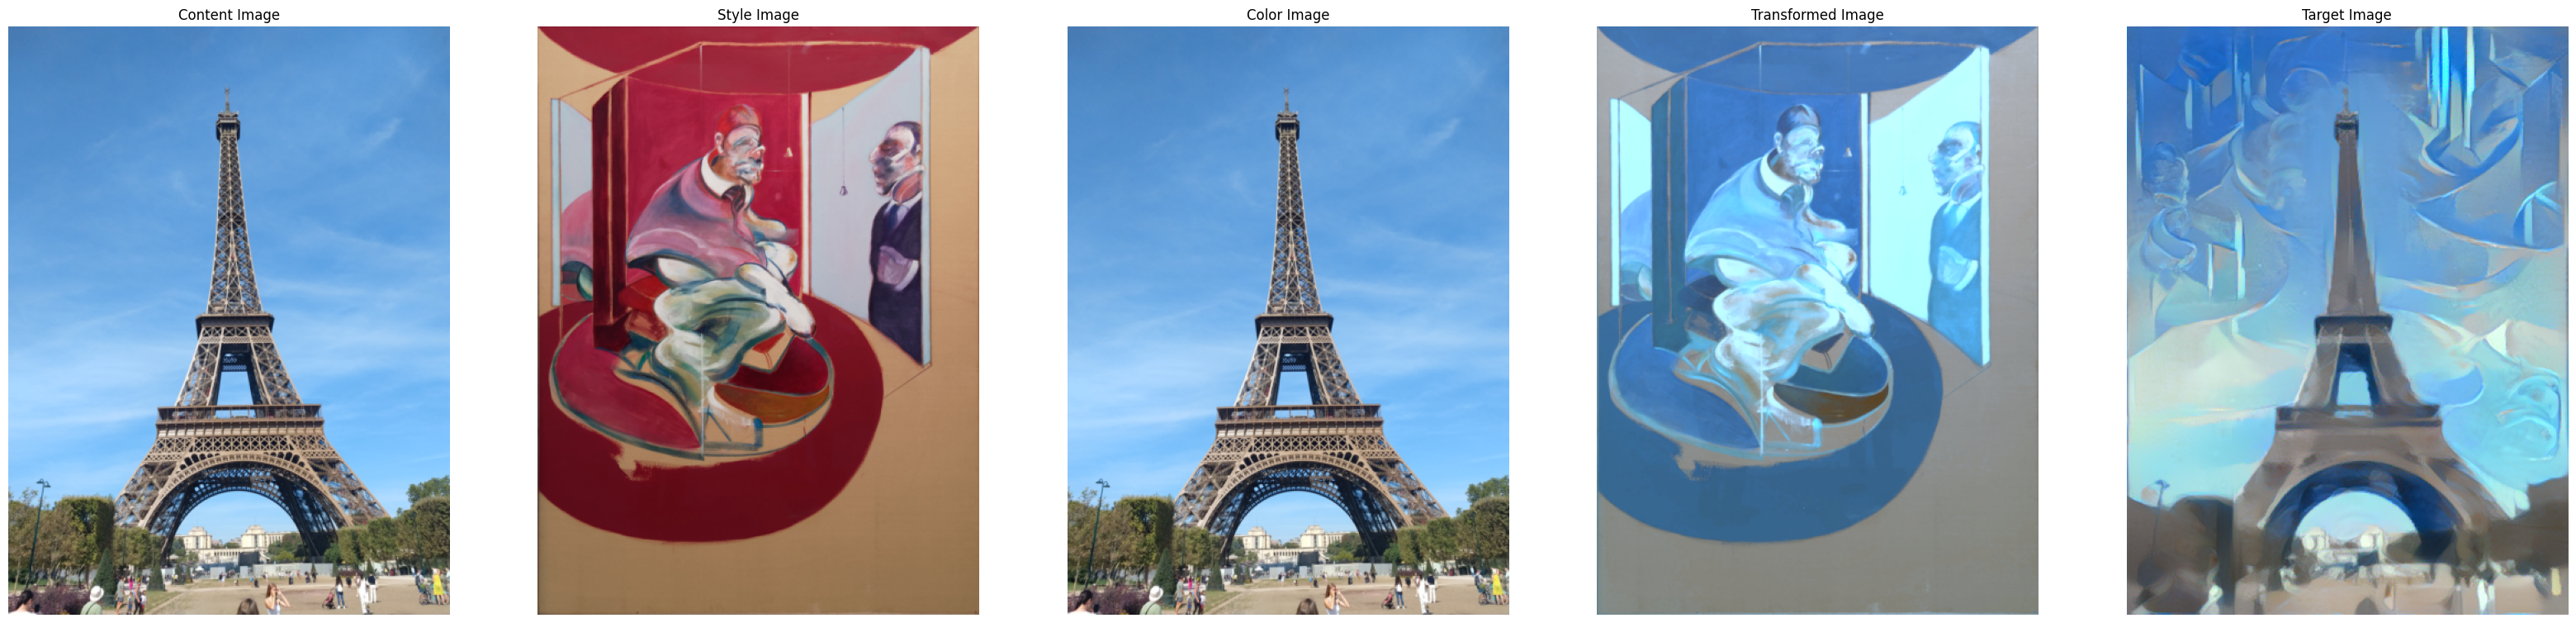

In [677]:
fig, (ax1, ax2, ax3,ax4, ax5) = plt.subplots(1, 5, figsize=(40, 20  ))
ax1.imshow(im_convert(content))
ax1.set_title('Content Image')
ax1.axis('off')

ax2.imshow(im_convert(style))
ax2.set_title('Style Image')
ax2.axis('off')

ax3.imshow(im_convert(color))
ax3.set_title('Color Image')
ax3.axis('off')

ax4.imshow(im_convert(transformed))
ax4.set_title('Transformed Image')
ax4.axis('off')

ax5.imshow(im_convert(target))
ax5.set_title('Target Image')
ax5.axis('off')

name_image = name_content + "_" + style_img + "_" + color_img  + ".png"

fig.savefig("test/"+name_image)

# Evaluation

In [678]:
import torch
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np

# Load Inception V3 model pre-trained on ImageNet
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()  # Use the model in evaluation mode
if torch.cuda.is_available():
    inception_model.cuda()

def get_inception_features(images, model, batch_size=32):
    """ Calculate the Inception model features for a set of images. """
    model.eval()
    all_features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = torch.stack(images[i:i + batch_size]).to('cuda')
            features = model(batch).detach().cpu().numpy()
            all_features.append(features)
    all_features = np.concatenate(all_features, axis=0)
    return all_features

def calculate_inception_score(features, eps=1e-16):
    """ Calculate the Inception Score given Inception model features. """
    softmax = np.exp(features) / np.sum(np.exp(features), axis=1, keepdims=True)
    marginal_mean = np.mean(softmax, axis=0)
    kl_div = softmax * (np.log(softmax + eps) - np.log(marginal_mean + eps))
    kl_mean = np.mean(np.sum(kl_div, axis=1))
    return np.exp(kl_mean)

def calculate_fid(real_features, fake_features):
    """ Calculate the Fréchet Inception Distance between real and fake features. """
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu_real - mu_fake) ** 2.0)
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juane\.conda\envs\cuda_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
